# Statistical Test

1. Do cluster have different binding affinities?
2. Are paratope sequences (or their identity scores) more similar within a checkpoint than between different checkpoints?

# Import

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from pymol import cmd
from collections import defaultdict, Counter 
from Bio.SeqUtils import seq1
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import matplotlib.cm as cm
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import mannwhitneyu



plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.titleweight'] = 'bold'


# Do cluster have different binding affinities? 

In [120]:
section = 'paratope' 

all_df = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/structural_{section}_all_information_final.csv")

all_df.rename(columns={"folder": "checkpoint"}, inplace=True)

if section.lower() == "paratope":
    manual_clusters = {
    "Cluster 1": ["5b8c", "5ggs"],
    "Cluster 2": ["9dq4", "9dq3", "5tru", "7su0", "7su1", "5jx3", "6rp8"],
    "Cluster 3": ["5ggr", "5wt9", "5ggv", "7bxa", "7cgw"],
    "Cluster 4": ["5x8l", "5xxy"],
    "Cluster 5": ["6txz"],
    "Cluster 6": ["7wvm", "8gy5"],
    }
else: 
    manual_clusters = {
    "Cluster 1": ["7su1", "6rp8", "7su0", "5tru", "5xj3", "9dq3", "5ggv", "9dq4"],
    "Cluster 2": ["6txz"],
    "Cluster 3": ["5grj", "5x8m", "5xj4", "5x8l", "5xxy"],
    "Cluster 4": ["5ggs", "5b8c", "7bxa", "6xkr", "5jxe", "7cgw"],
    "Cluster 5": ["6k0y", "5wt9", "5ggr", "7cu5", "8gy5", "7wsl", "7wvm"],

}

# Convert manual Cluster-Dict in list 
cluster_rows = []
for cluster_name, pdb_list in manual_clusters.items():
    for pdb in pdb_list:
        cluster_rows.append({"pdb_id": pdb, "cluster": cluster_name})

# DF
cluster_df = pd.DataFrame(cluster_rows)

# 3. Merge with main df 
merged_df = cluster_df.merge(all_df[["pdb_id", "binding_score", "checkpoint"]], on="pdb_id", how="left")

print(merged_df)

   pdb_id    cluster  binding_score checkpoint
0    5b8c  Cluster 1       0.191828        pd1
1    5b8c  Cluster 1       0.191828        pd1
2    5b8c  Cluster 1       0.191828        pd1
3    5b8c  Cluster 1       0.191828        pd1
4    5ggs  Cluster 1       0.289538        pd1
5    5ggs  Cluster 1       0.289538        pd1
6    9dq4  Cluster 2       0.951521      ctla4
7    9dq3  Cluster 2       0.376213      ctla4
8    5tru  Cluster 2       0.101403      ctla4
9    5tru  Cluster 2       0.101403      ctla4
10   7su0  Cluster 2       0.142831      ctla4
11   7su0  Cluster 2       0.142831      ctla4
12   7su1  Cluster 2       0.313449      ctla4
13   5jx3  Cluster 2            NaN        NaN
14   6rp8  Cluster 2       0.067610      ctla4
15   6rp8  Cluster 2       0.067610      ctla4
16   5ggr  Cluster 3       0.099924        pd1
17   5ggr  Cluster 3       0.099924        pd1
18   5wt9  Cluster 3       0.099323        pd1
19   5ggv  Cluster 3       0.137464      ctla4
20   7bxa  Cl

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/720140290.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

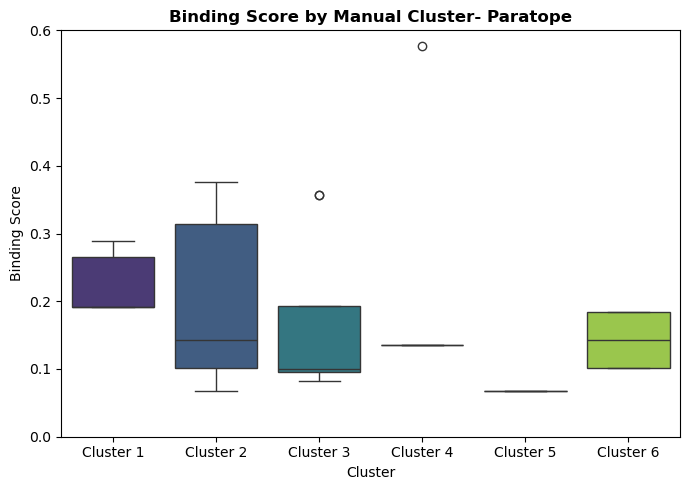

In [121]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="viridis")

plt.title(f"Binding Score by Manual Cluster- {section.capitalize()}")
plt.xlabel("Cluster")
plt.ylabel("Binding Score")
plt.tight_layout()
plt.ylim(0, 0.6)

plt.savefig(f"plots/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_binding_score_by_cluster.pdf", bbox_inches='tight')


In [122]:
# group by cluster 
grouped_scores = [
    group["binding_score"].dropna().values
    for name, group in merged_df.groupby("cluster")
]

# Kruskal–Wallis-Test
stat, p = kruskal(*grouped_scores)

print(f"Kruskal–Wallis-Test: H = {stat:.3f}, p = {p:.4e}")

Kruskal–Wallis-Test: H = 14.786, p = 1.1315e-02


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font

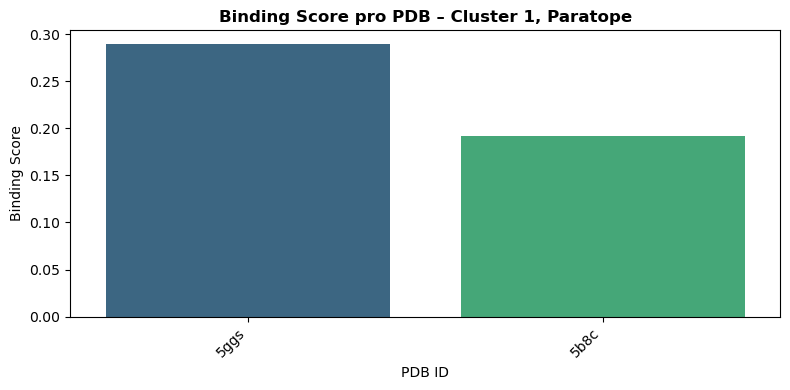

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font

<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

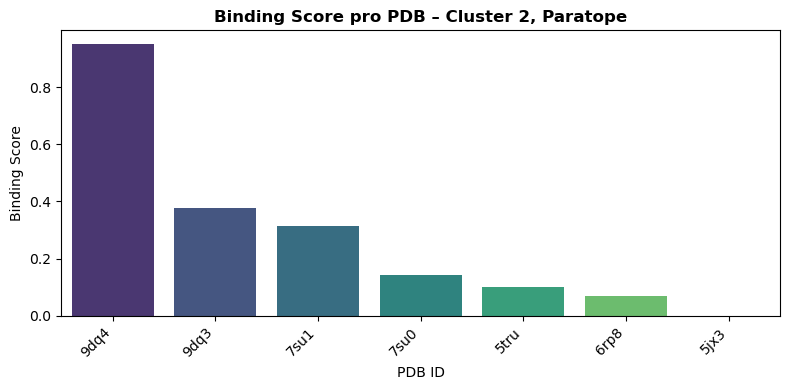

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font

<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

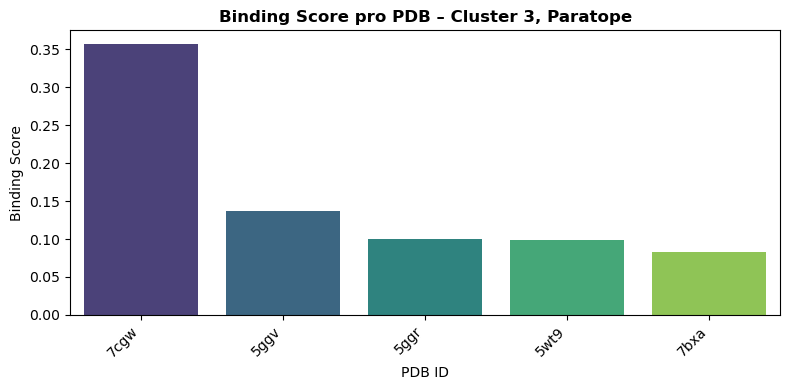

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

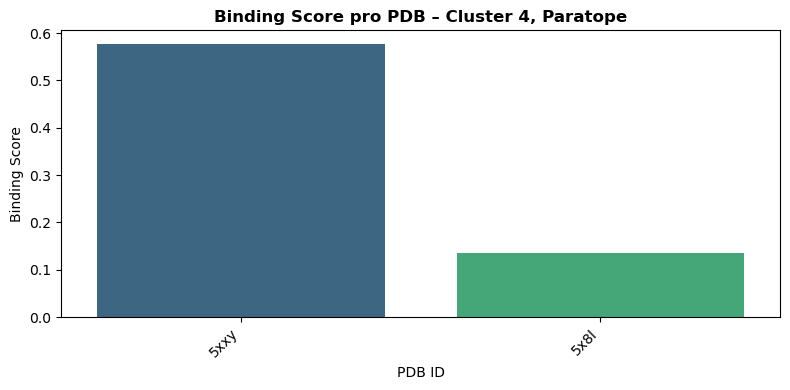

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

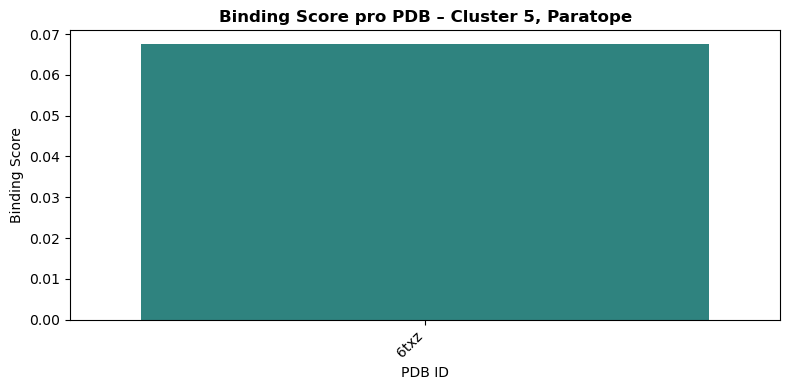

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

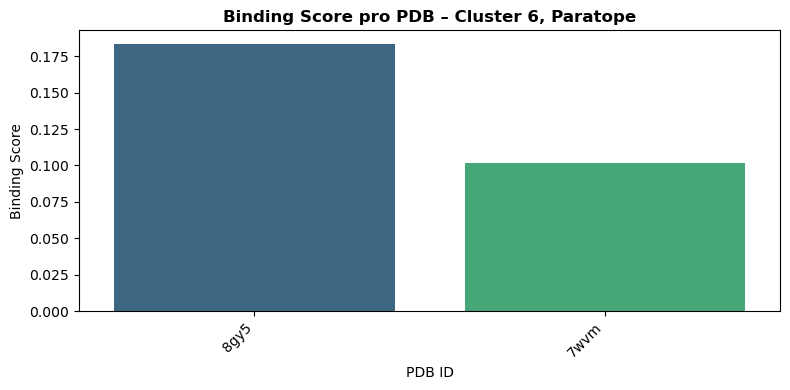

<Figure size 640x480 with 0 Axes>

In [123]:
clusters = merged_df["cluster"].unique()

# Plot per Cluster
for cluster_name in clusters:
    subset = merged_df[merged_df["cluster"] == cluster_name].sort_values("binding_score", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
    plt.title(f"Binding Score pro PDB – {cluster_name}, {section.capitalize()}")
    plt.xlabel("PDB ID")
    plt.ylabel("Binding Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"plots/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_Binding Score pro PDB – {cluster_name}.pdf", bbox_inches='tight')



In [124]:
all_df.rename(columns={"folder": "checkpoint"}, inplace=True)

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/401645173.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#404688", "#21908d"])
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not 

Mann–Whitney U-Statistik: 52677.00
P-Wert: 0.0054


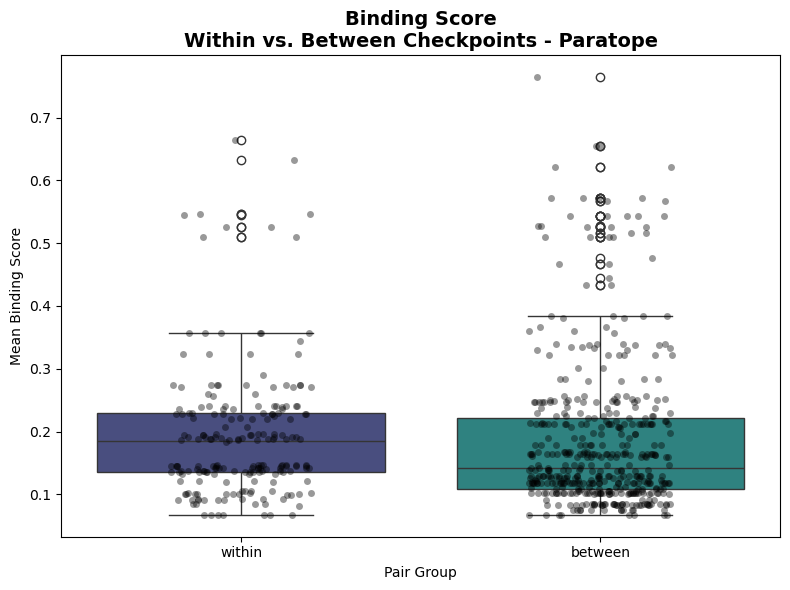

In [125]:
# Drop NaNs in binding_score or checkpoint 
clean_df = merged_df.dropna(subset=["binding_score", "checkpoint"])

# Generate all pairwise combinations
pairs = []
for (p1, row1), (p2, row2) in combinations(clean_df.iterrows(), 2):
    score1 = row1["binding_score"]
    score2 = row2["binding_score"]

    if pd.notna(score1) and pd.notna(score2):
        pairs.append({
            "pdb_1": row1["pdb_id"],
            "pdb_2": row2["pdb_id"],
            "mean_binding": (score1 + score2) / 2,
            "same_checkpoint": row1["checkpoint"] == row2["checkpoint"],
        })

# Create DataFrame and group labels
df_binding_pairs = pd.DataFrame(pairs)
df_binding_pairs = df_binding_pairs.dropna(subset=["mean_binding"])
df_binding_pairs["group"] = df_binding_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Statistical test
within = df_binding_pairs[df_binding_pairs["group"] == "within"]["mean_binding"]
between = df_binding_pairs[df_binding_pairs["group"] == "between"]["mean_binding"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#404688", "#21908d"])
sns.stripplot(data=df_binding_pairs, x="group", y="mean_binding", color='black', alpha=0.4, jitter=0.2)

plt.title(f"Binding Score\nWithin vs. Between Checkpoints - {section.capitalize()}", fontsize=14)
plt.ylabel("Mean Binding Score")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


# Are paratope sequences (or their identity scores) more similar within a checkpoint than between different checkpoints?

In [126]:
# Read the file using the first column as index
df_identity = pd.read_csv(
    "data/structural_analysis/Paratope/paratope_sequence_comparison_matrix.csv",
    index_col=0
)

# Make sure index and column names are strings and lowercase
df_identity.index = df_identity.index.astype(str).str.lower()
df_identity.columns = df_identity.columns.astype(str).str.lower()

# Also convert merged_df pdb_ids if not already done
merged_df["pdb_id"] = merged_df["pdb_id"].astype(str).str.lower()




In [127]:
df_identity

,5tru_id1,6rp8_id1,6rp8_id2,5xj3_id1,5xj3_id2,5xj3_id3,9dq4,5tru_id2,5xj3_id4,5ggv,...,5xj4,5xxy,5x8l_id3,5x8l_id4,5x8m,5x8l_id5,6txz_id1,6txz_id2,6txz_id3,6txz_id4
5tru_id1,100.00,85.71,77.78,57.14,71.43,85.71,38.46,55.56,85.71,44.44,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,42.86,42.86,42.86
6rp8_id1,85.71,100.00,77.78,57.14,71.43,85.71,30.77,55.56,71.43,44.44,...,14.29,18.75,30.00,27.27,42.86,33.33,33.33,42.86,42.86,42.86
6rp8_id2,77.78,77.78,100.00,55.56,66.67,77.78,38.46,77.78,66.67,44.44,...,33.33,31.25,50.00,45.45,44.44,55.56,44.44,44.44,33.33,44.44
5xj3_id1,57.14,57.14,55.56,100.00,83.33,71.43,30.77,44.44,57.14,33.33,...,40.00,18.75,30.00,27.27,42.86,33.33,22.22,28.57,28.57,28.57
5xj3_id2,71.43,71.43,66.67,83.33,100.00,85.71,38.46,55.56,71.43,33.33,...,33.33,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
5xj3_id3,85.71,85.71,77.78,71.43,85.71,100.00,38.46,66.67,85.71,33.33,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
9dq4,38.46,30.77,38.46,30.77,38.46,38.46,100.00,38.46,38.46,30.77,...,15.38,31.25,38.46,38.46,23.08,38.46,30.77,30.77,23.08,23.08
5tru_id2,55.56,55.56,77.78,44.44,55.56,66.67,38.46,100.00,55.56,44.44,...,33.33,31.25,50.00,45.45,33.33,55.56,33.33,22.22,33.33,22.22
5xj3_id4,85.71,71.43,66.67,57.14,71.43,85.71,38.46,55.56,100.00,33.33,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
5ggv,44.44,44.44,44.44,33.33,33.33,33.33,30.77,44.44,33.33,100.00,...,22.22,31.25,30.00,36.36,33.33,44.44,44.44,44.44,44.44,55.56


In [128]:

pairs = []

for pdb1, pdb2 in combinations(df_identity.index, 2):
    if pdb1 not in merged_df["pdb_id"].values or pdb2 not in merged_df["pdb_id"].values:
        continue  
    
    identity = df_identity.loc[pdb1, pdb2]
    
    # checkpoints
    cp1 = merged_df[merged_df["pdb_id"] == pdb1]["checkpoint"]
    cp2 = merged_df[merged_df["pdb_id"] == pdb2]["checkpoint"]
    
    if cp1.empty or cp2.empty:
        continue
    
    group1 = cp1.values[0]
    group2 = cp2.values[0]
    same_group = group1 == group2

    pairs.append({
        "pdb1": pdb1,
        "pdb2": pdb2,
        "identity": identity,
        "same_checkpoint": same_group
    })

df_pairs = pd.DataFrame(pairs)



In [129]:
from scipy.stats import mannwhitneyu

within = df_pairs[df_pairs["same_checkpoint"] == True]["identity"]
between = df_pairs[df_pairs["same_checkpoint"] == False]["identity"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")

Mann–Whitney U-Statistik: 41.50
P-Wert: 0.0486


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/3654358654.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#404688", "#21908d"])
/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_4620/3654358654.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_pairs, x="group", y="identity", palette=["#440154", "#21908d"], alpha=0.4, jitter=0.2)
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font f

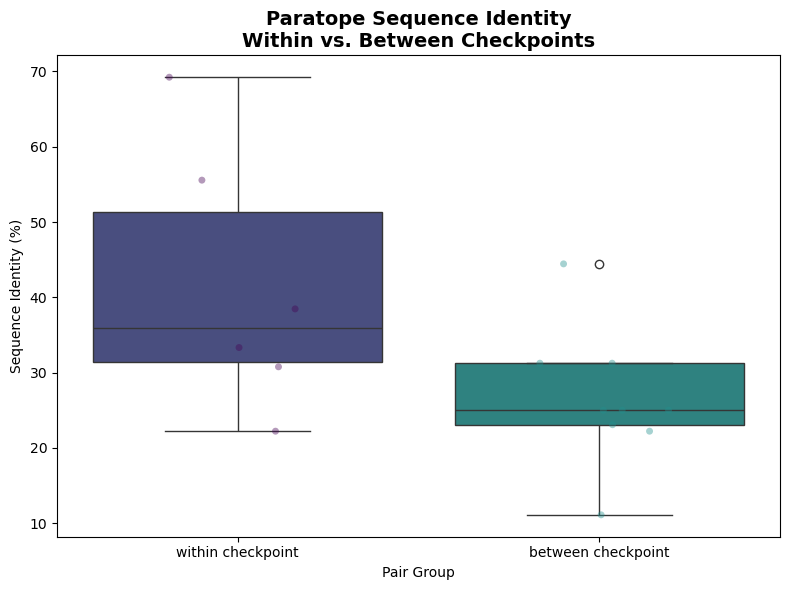

In [130]:

# 'same_checkpoint' als bool-Typ sichern
df_pairs["same_checkpoint"] = df_pairs["same_checkpoint"].astype(bool)

# Labels
df_pairs["group"] = df_pairs["same_checkpoint"].map({True: "within checkpoint", False: "between checkpoint"})

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#404688", "#21908d"])
sns.stripplot(data=df_pairs, x="group", y="identity", palette=["#440154", "#21908d"], alpha=0.4, jitter=0.2)
plt.title(f"{section.capitalize()} Sequence Identity\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Sequence Identity (%)")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()




In [131]:
wanted_best_pdbs = ['5xj4', '5x8m', '7bxa', '7cgw', '5b8c', '5ggs', '5jxe', '5x8l',
       '5xxy', '5wt9', '5ggr']

filtered_best_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

filtered_best_df.to_csv(f'data/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_filtered_pdbs_best.csv', index=False)

In [132]:
wanted_worst_pdbs = ['7wsl', '7wvm', '8gy5', '5grj', '6rp8', '5xj3', '9dq4', '7su0',
       '5tru', '7su1', '9dq3']

filtered_worst_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

filtered_worst_df.to_csv(f'data/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_filtered_pdbs_worst.csv', index=False)